In [52]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (7, 7)
plt.set_cmap("viridis")

import numpy as np

In [2]:
from carl.data import GK
gk = GK(A=3., B=1., g=2., k=0.5)
X_true = gk.rvs(10000)

In [ ]:
from carl.distributions import Normal
p1 = Normal(mu=np.mean(X_true), sigma=np.std(X_true) * 3)

# Full-scan version

In [63]:
from carl.ratios import CalibratedClassifierRatio
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import ElasticNetCV
from sklearn.model_selection import StratifiedShuffleSplit

def objective(X, theta, random_state=0):
    gk.A.set_value(theta[0])
    gk.B.set_value(theta[1])
    gk.g.set_value(theta[2])
    gk.k.set_value(theta[3])
    
    gk.set_params(random_state=random_state)
    p1.set_params(random_state=random_state+1)
    
    cc = CalibratedClassifierRatio(
        base_estimator=MLPRegressor(learning_rate="adaptive", random_state=random_state), 
        cv=StratifiedShuffleSplit(n_iter=1, test_size=0.75, random_state=random_state),
        calibration="isotonic")
    cc.fit(numerator=gk, denominator=p1, n_samples=10000)
    r = cc.predict(X, log=True)

    return -np.mean(r[np.isfinite(r)])

def bootstrap(n_trials, X, func, **kwargs):
    scores = []
    
    for i in range(n_trials):
        indices = np.random.randint(0, len(X), len(X))
        scores.append(func(X[indices], random_state=i, **kwargs))
        
    return np.mean(scores)

In [64]:
import itertools

As = np.linspace(0, 4, num=15)
Bs = np.linspace(0, 4, num=15)[1:]
values = []

for A, B in itertools.product(As, Bs):
    values.append(-bootstrap(3, X_true, objective, theta=[A, B, 2, 0.5]))

/home/gilles/src/scikit-learn/sklearn/neural_network/multilayer_perceptron.py:554: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


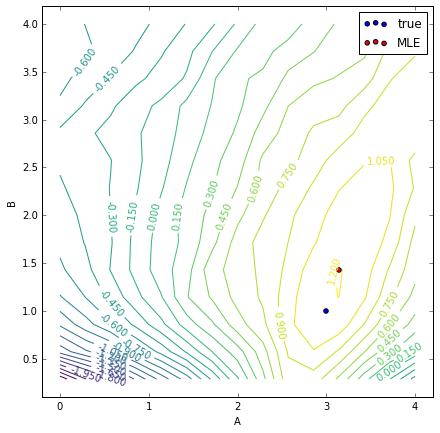

In [65]:
AA, BB = np.meshgrid(As, Bs)
CS = plt.contour(AA, BB, np.array(values).reshape((len(As), len(Bs))).T, 30)
plt.clabel(CS, inline=1, fontsize=10)

best_A = As[np.argmax(values) // len(Bs)]
best_B = Bs[np.argmax(values) % len(Bs)]

plt.xlabel("A")
plt.ylabel("B")

plt.scatter([3], [1], label="true")
plt.scatter([best_A], [best_B], c="r", label="MLE")
plt.legend()

plt.show()